In [1]:
# Install Eigen
# You need to turn on "Internet" from Settings on the right panel
! apt install libeigen3-dev

# Download code from github
%cd /tmp
! git clone https://github.com/junkoda/junkoda_cellularlib.git

%cd /tmp/junkoda_cellularlib/py

# Specify the version in case backward compatibility is lost
! git checkout bc97d6ab419d8e9e1c295a7662d94cfd1f5b3501

# Compile the library
! make

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  libeigen3-doc libmpfrc++-dev
The following NEW packages will be installed:
  libeigen3-dev
0 upgraded, 1 newly installed, 0 to remove and 67 not upgraded.
Need to get 1056 kB of archives.
After this operation, 9081 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libeigen3-dev all 3.4.0-2ubuntu2 [1056 kB]
Fetched 1056 kB in 1s (879 kB/s)        

78Selecting previously unselected package libeigen3-dev.
(Reading database ... 115376 files and directories currently installed.)
Preparing to unpack .../libeigen3-dev_3.4.0-2ubuntu2_all.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 20%] [###########...............................................] 8Unpacking libeigen3-dev (3.4.0-2ubuntu2) ...
7Progress: [ 40%] [#######################..............................

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import junkoda_cellularlib as cellularlib

from scipy.signal import find_peaks
from sklearn.neighbors import KernelDensity

img shape (6, 512, 512)


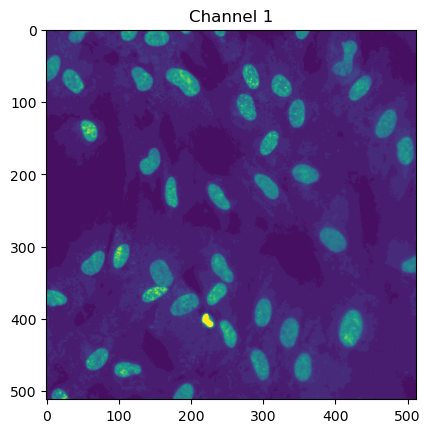

In [3]:
cellularlib.data.set_data_dir('/kaggle/input/recursion-cellular-image-classification')
img = cellularlib.data.load('train', 'RPE-01_1_B03', site=1)

print('img shape', img.shape)

plt.title('Channel 1')
plt.imshow(img[0, ])  # channel 1
plt.clim(0, 0.1)
plt.show()

Find the brightness distribution of nuclei pixels
This may be useful to determine the overall normalisation of the image brightness.

**Definition**
cluster is a connected component of pixels above some threshold; img >= threshold;
4 adjacent pixels are connected;
size of a cluster is the number of pixels that belongs to that cluster;
**Algorithm**
Pixels are explored in a "watershed" way, from highest peak to lower. A pixel belongs to nuclei if it belongs to some cluster of size between size_min and size_max for some threshold. The code is in watershed_nuclei.cpp.

shape (512, 512)


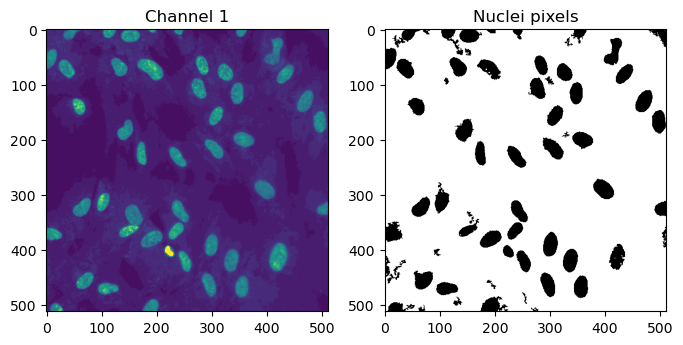

In [4]:
# Binary mask: 1 for nuclei pixel in the algorithm above, 0 otherwise
nuclei = cellularlib.threshold.obtain_nuclei_pixels(img[0,], size_min=50, size_max=1000)
# Good size_min may depend on the cell_line, HUVEC2, RPE, ...

print('shape', nuclei.shape)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Channel 1')
plt.imshow(img[0, ])
plt.clim(0, 0.1)

plt.subplot(1, 2, 2)
plt.title('Nuclei pixels')
plt.imshow(nuclei, cmap='Greys')
plt.show()

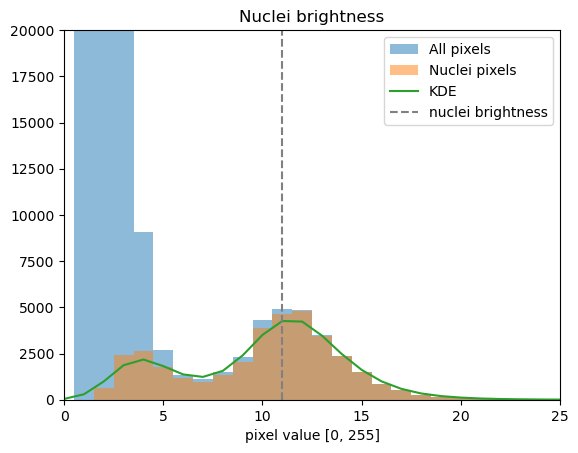

In [5]:
# Pixel values of nuclei pixels (converted to range [0, 255])
values = img[0,].flatten()[nuclei.flatten()]*255

# Kernel density estimation
kde = KernelDensity(kernel='gaussian', bandwidth=1.0)
# Extra smoothness, e.g., bandwidth = 2 may be better for stability.
kde.fit(values.reshape(-1, 1))
x = np.arange(40)
f = np.exp(kde.score_samples(x.reshape(-1, 1)))*len(values)


# Find peaks
height_threshold = 0.1*np.max(f)
peaks = find_peaks(f, height_threshold)[0]
x_peaks = x[peaks]
nuclei_brightness = x_peaks[-1]

bins = 0.5 + np.arange(40)
plt.figure()
plt.title('Nuclei brightness')
plt.xlim(0, 25)
plt.ylim(0, 20000)
plt.xlabel('pixel value [0, 255]')
plt.hist(img[0, ].flatten()*255, bins, alpha=0.5, label='All pixels')
plt.hist(values, bins, alpha=0.5, label='Nuclei pixels')
plt.plot(x, f, label='KDE')
plt.axvline(nuclei_brightness, ls='--', color='gray', label='nuclei brightness')
plt.legend()
plt.show()

**Fitting nuclei with ellipses**
The mean and covariance matrix of each cluster, or in physics, center of mass and moment of inertia, are computed. Diagonalizing the matrix gives the major and minor axes of an ellipse.

In [6]:
threshold = 0.6*nuclei_brightness/255  # convert back [0, 255] to [0, 1.0]
es = cellularlib.ellipses.obtain(img[0,], threshold, 50)  # 50 is the minimum size

# size x y semi-major axis semi-minor axis theta
# theta is the angle between the major axis and x axis in radian
es[:3, ]

array([[367.        ,   7.76566757,  43.88555858,  18.66740068,
         10.28922178,  -1.08409001],
       [314.        ,   6.74522293, 114.15605096,  14.89675109,
         10.48361835,  -1.33537955],
       [ 82.        ,   2.3902439 , 192.54878049,   9.57727118,
          4.4417572 ,   4.60039533]])

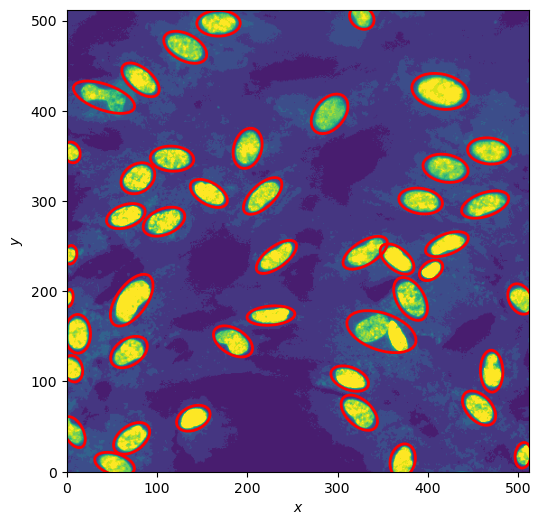

In [7]:
plt.figure(figsize=(6, 6))
cellularlib.ellipses.plot(es, img[0,])
plt.clim(0, 0.05)

**Number of clusters - threshold relation**

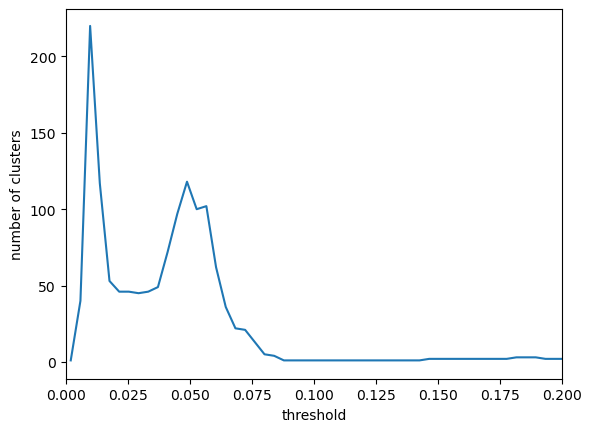

In [8]:
thresholds, nclusters = cellularlib.compute_nclusters(img[0,], size_threshold=5)

plt.xlabel('threshold')
plt.ylabel('number of clusters')
plt.xlim(0, 0.2)
plt.plot(thresholds, nclusters)
plt.show()

From right to left, as the threshold goes down, the number of clusters first increses, then as clusters merge, the number decreases, and then there is a second peak on the left due to noise.